In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

df=pd.read_csv('../data/us_disaster_declarations.csv')

## 2. EDA

### 2.1 Explore the Data

In [50]:
# Convert 'declaration_date' obj to dtm in new 'declaration_dtm' column
df['declaration_dtm']=pd.to_datetime(df['declaration_date'], format='%Y-%m-%dT%H:%M:%SZ')

# Create resampled_df containing 'state', 'declaration_dtm', and 'incident_type'
resampled_df=(df.assign(date=lambda d: pd.to_datetime(d['declaration_dtm'], format="%Y-%m-%d"))[['state', 'declaration_dtm', 'incident_type']])

In [51]:
# Floor day of the month so that all incidents are reported on the same day monthly (for monthly counts)
# Create 'month' column to filter month from 'declaration_dtm'
df['month']=pd.to_datetime(df['declaration_dtm'], format='%b').dt.month

# Create 'year' column to filter year from 'declaration_dtm'
df['year']=pd.to_datetime(df['declaration_dtm'], format='%Y').dt.year

# Create 'date' column with year-month format of each incident, with day assigned to 1
df['date']=pd.to_datetime(df[['year', 'month']].assign(day=1))

# Create 'doy' column to extract the day of the year
df['doy'] = df.date.dt.day_of_year

df.head()

,fema_declaration_string,disaster_number,state,declaration_type,declaration_date,fy_declared,incident_type,declaration_title,ih_program_declared,ia_program_declared,...,declaration_request_number,last_ia_filing_date,last_refresh,hash,id,declaration_dtm,month,year,date,doy
0,DR-1-GA,1,GA,DR,1953-05-02T00:00:00Z,1953,Tornado,Tornado,0,1,...,53013,NaN,2023-03-18T13:22:03Z,48af1afcc4535aa910ddb5b85eebe047dc703a6b,da5c8f17-c28f-4c41-8e06-fa8efc85aa4a,1953-05-02,5,1953,1953-05-01,121
1,DR-2-TX,2,TX,DR,1953-05-15T00:00:00Z,1953,Tornado,Tornado & Heavy Rainfall,0,1,...,53003,NaN,2023-03-18T13:22:03Z,6bbba411d294ec521683e36313c8da2992e8a857,b0b41f55-0d77-43ac-898c-3cc4a18231e6,1953-05-15,5,1953,1953-05-01,121
2,DR-3-LA,3,LA,DR,1953-05-29T00:00:00Z,1953,Flood,Flood,0,1,...,53005,NaN,2023-03-18T13:22:03Z,5b2fa18b404bdcf0d3038cd17f1aa995d5412f48,9fd9401d-c76c-43c3-b42a-6a4ae5139ec0,1953-05-29,5,1953,1953-05-01,121
3,DR-4-MI,4,MI,DR,1953-06-02T00:00:00Z,1953,Tornado,Tornado,0,1,...,53004,NaN,2023-03-18T13:22:03Z,403164346eb22263810402e8b67f1712f1574ad5,67324f38-1f00-4bbc-aeda-5194d1befad6,1953-06-02,6,1953,1953-06-01,152
4,DR-5-MT,5,MT,DR,1953-06-06T00:00:00Z,1953,Flood,Floods,0,1,...,53006,NaN,2023-03-18T13:22:03Z,8c775d2ce843a8eba2417f9716ba5c75fe0e53f3,e3853916-c7a2-4557-ad8e-60a42d369a61,1953-06-06,6,1953,1953-06-01,152


In [55]:
# Create subset_df with reformatted 'date', 'incident_type', and 'state'
subset_df=df[['date', 'incident_type', 'state', 'doy', 'year']]

# Create 'count' column to count the number of disasters reported based on 'date'
subset_df['counts'] = df.groupby(['date'])['date'].transform('count')

subset_df.head()

/tmp/ipykernel_6600/823088087.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['counts'] = df.groupby(['date'])['date'].transform('count')


,date,incident_type,state,doy,year,counts
0,1953-05-01,Tornado,GA,121,1953,3
1,1953-05-01,Tornado,TX,121,1953,3
2,1953-05-01,Flood,LA,121,1953,3
3,1953-06-01,Tornado,MI,152,1953,6
4,1953-06-01,Flood,MT,152,1953,6


In [19]:
# Examine disaster types
disaster_types=df['incident_type'].unique()
print("Types of Disasters reported:\n\n", disaster_types)
print("Occurrences:\n\n",df['incident_type'].value_counts())

Types of Disasters reported:

 ['Tornado' 'Flood' 'Fire' 'Other' 'Earthquake' 'Hurricane'
 'Volcanic Eruption' 'Severe Storm' 'Toxic Substances' 'Typhoon' 'Drought'
 'Dam/Levee Break' 'Snowstorm' 'Severe Ice Storm' 'Freezing'
 'Coastal Storm' 'Fishing Losses' 'Mud/Landslide' 'Human Cause'
 'Terrorist' 'Tsunami' 'Chemical' 'Biological' 'Tropical Storm'
 'Winter Storm']
Occurrences:

 incident_type
Severe Storm         17490
Hurricane            13045
Flood                10693
Biological            7857
Snowstorm             3707
Fire                  3615
Severe Ice Storm      2942
Tornado               1569
Drought               1292
Coastal Storm          637
Other                  307
Freezing               301
Earthquake             228
Typhoon                130
Tropical Storm          54
Volcanic Eruption       51
Winter Storm            43
Fishing Losses          42
Mud/Landslide           37
Dam/Levee Break         13
Toxic Substances         9
Tsunami                  9
Chemic

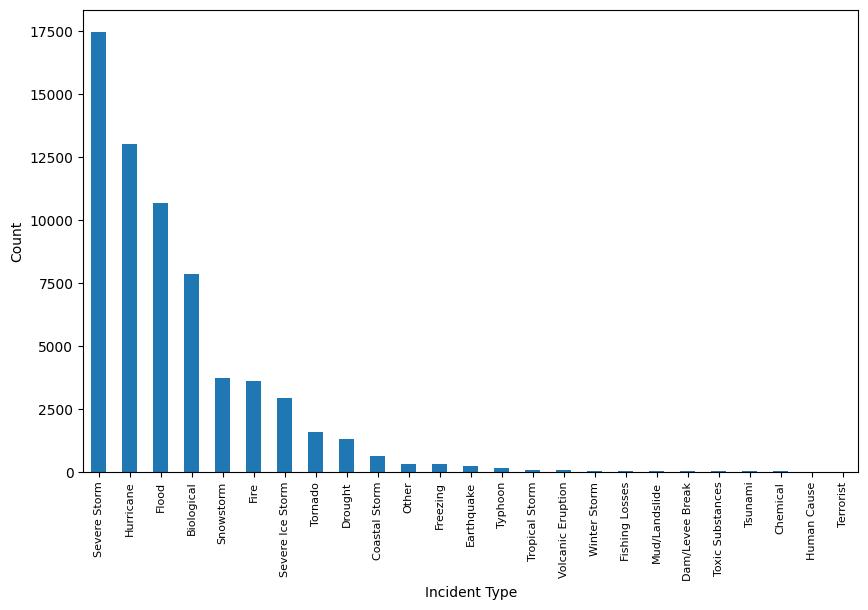

In [ ]:
# Plot disaster types/count - extract the counts for each state
type_counts=df['incident_type'].value_counts(ascending=False)

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Plot the bar plot
type_counts.plot(kind='bar')

# Set title and labels
plt.xlabel('Incident Type')
plt.ylabel('Count')

# Rotate x-axis labels for better readability and increase font size
plt.xticks(rotation=90, fontsize=8)

# Show plot
plt.show()

In [20]:
# Examine disaster locations (state)
disaster_loc=df['state'].unique()
print("Location of Disasters reported:\n\n", disaster_loc)
print("Occurrences:\n\n",df['state'].value_counts())

Location of Disasters reported:

 ['GA' 'TX' 'LA' 'MI' 'MT' 'IA' 'MA' 'NH' 'FL' 'AK' 'MS' 'CA' 'NV' 'SD'
 'WV' 'RI' 'ME' 'CT' 'NY' 'NM' 'SC' 'NC' 'IN' 'HI' 'CO' 'KS' 'OK' 'NJ'
 'PA' 'OR' 'WA' 'ID' 'OH' 'PR' 'KY' 'VA' 'MO' 'AR' 'MN' 'ND' 'IL' 'NE'
 'AL' 'MD' 'DE' 'GU' 'TN' 'FM' 'WY' 'VT' 'VI' 'WI' 'AS' 'AZ' 'MP' 'UT'
 'MH' 'DC' 'PW']
Occurrences:

 state
TX    5173
MO    2704
KY    2583
VA    2524
LA    2493
OK    2474
FL    2352
GA    2278
NC    2096
PR    1987
MS    1906
IA    1848
KS    1759
AL    1665
TN    1605
CA    1599
AR    1593
MN    1563
NY    1503
NE    1485
IN    1451
SD    1430
ND    1359
IL    1283
OH    1281
PA    1239
WV    1232
ME    1019
WA     979
SC     947
WI     892
MI     796
CO     646
NJ     625
MT     605
OR     586
NM     514
MD     448
MA     398
ID     361
VT     338
AZ     335
AK     318
NH     301
NV     274
CT     255
UT     249
WY     128
RI     114
HI     100
VI      80
AS      76
MP      63
DE      53
MH      53
FM      31
DC      23
GU      19
PW    

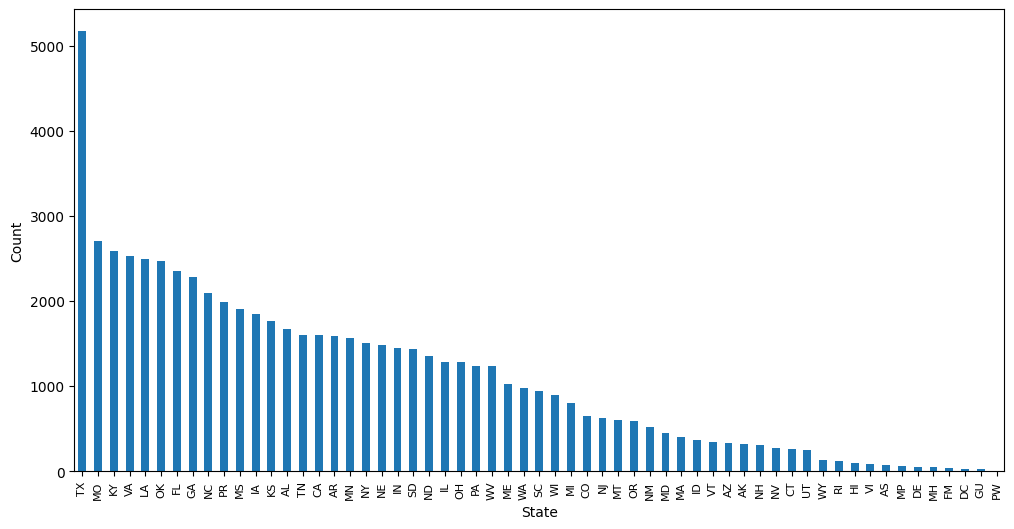

In [ ]:
# Plot disaster locations/count - extract the counts for each state
state_counts=df['state'].value_counts(ascending=False)

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Plot the bar plot
state_counts.plot(kind='bar')

# Set title and labels
plt.xlabel('State')
plt.ylabel('Count')

# Rotate x-axis labels for better readability and increase font size
plt.xticks(rotation=90, fontsize=8)

# Show plot
plt.show()

In [32]:
# Count by disasters annually
df['year']=pd.to_datetime(df['declaration_dtm'], format='%Y').dt.year
disaster_yr=df['year'].unique()
print("Year of Disasters reported:\n\n", disaster_yr)
print("Occurrences:\n\n",df['year'].value_counts())

Year of Disasters reported:

 [1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966
 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980
 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022
 2023]
Occurrences:

 year
2020    9712
2005    4736
2011    2690
2008    2300
2021    1964
        ... 
1953      13
1961      12
1960      12
1959       7
1958       7
Name: count, Length: 71, dtype: int64


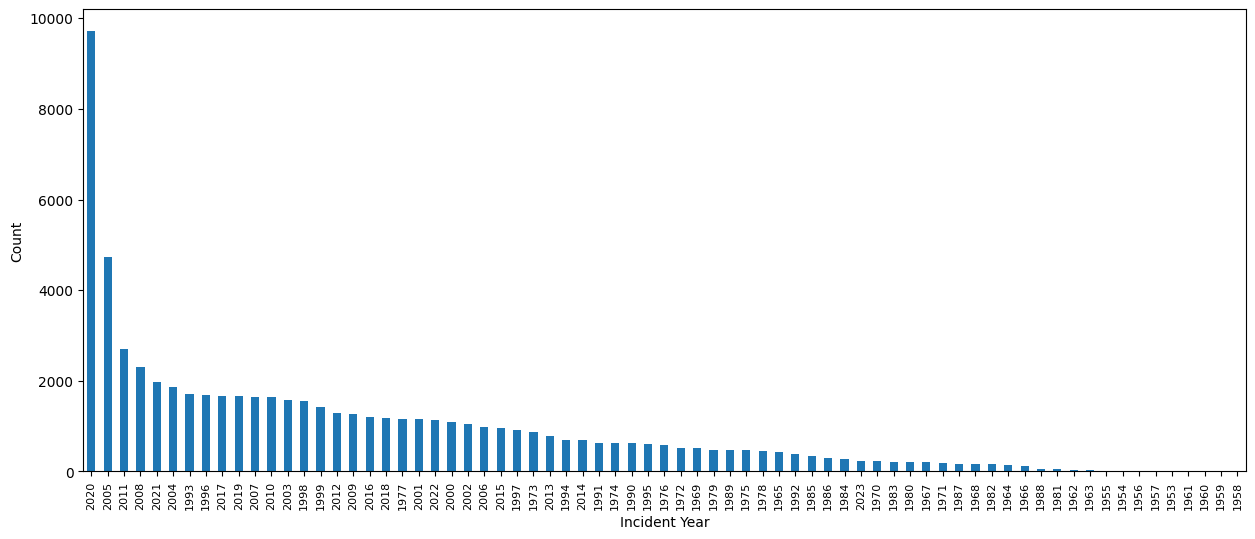

In [6]:
# Bar plot disaster year/count - extract the counts for each state
year_counts=df['year'].value_counts(ascending=False)

# Set the size of the plot
plt.figure(figsize=(15, 6))

# Plot the bar plot
year_counts.plot(kind='bar')

# Set title and labels
plt.xlabel('Incident Year')
plt.ylabel('Count')

# Rotate x-axis labels for better readability and increase font size
plt.xticks(rotation=90, fontsize=8)

# Show plot
plt.show()

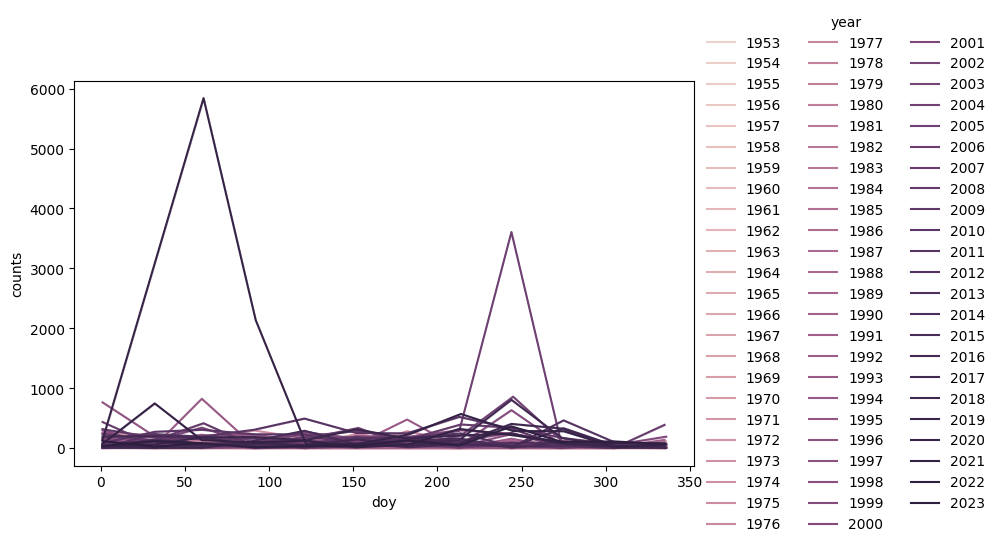

In [56]:
# Line plot disaster year/count 
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=subset_df, x='doy', y='counts', hue='year', legend='full', ax=ax)
sns.move_legend(ax, bbox_to_anchor=(1, 0.5), loc='center left', frameon=False, ncols=3)

In [ ]:
# Examine which states are prone to which disaster types
state_types=df[['state','incident_type']].groupby('state').describe()
state_types['incident_type'].sort_values(by='count',ascending=False).head(10)

,count,unique,top,freq
state,,,,
TX,5173,11,Hurricane,1303
MO,2704,8,Severe Storm,1339
KY,2583,10,Severe Storm,999
VA,2524,11,Hurricane,877
LA,2493,11,Hurricane,1364
OK,2474,9,Severe Storm,1005
FL,2352,11,Hurricane,1219
GA,2278,10,Hurricane,905
NC,2096,10,Hurricane,1304


In [8]:
# Examine states hit most frequently by one type of disaster
state_types['incident_type'].sort_values(by='freq',ascending=False)['freq'].head(10)

state
LA    1364
MO    1339
NC    1304
TX    1303
FL    1219
KS    1030
PR    1024
OK    1005
KY     999
GA     905
Name: freq, dtype: object

In [ ]:
# Examine states at highest risk
state_risk= df[['state','incident_type']].groupby('state').count()
state_risk.reset_index(inplace=True)
state_risk=state_risk.sort_values(by='incident_type',ascending=False).head(10)
state_risk

,state,incident_type
50,TX,5173
28,MO,2704
20,KY,2583
52,VA,2524
21,LA,2493
41,OK,2474
10,FL,2352
12,GA,2278
32,NC,2096
44,PR,1987


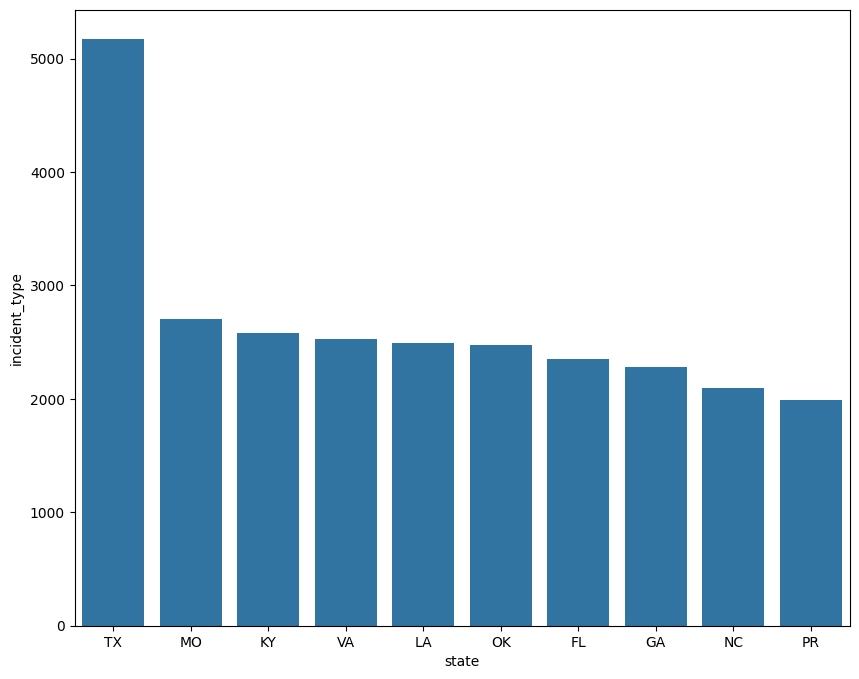

In [10]:
# Plot states at highest risk
plt.figure(figsize=(10,8))
sns.barplot(x="state", y="incident_type", data=state_risk);

In [4]:
# Examine count based on date
count_date=date_df.date.value_counts().reset_index()    

count_date.head(10)

,date,count
0,2020-03-01,5842
1,2005-09-01,3607
2,2020-04-01,2138
3,2004-09-01,859
4,1993-03-01,824
5,2017-09-01,807
6,1996-01-01,764
7,2021-02-01,747
8,1999-09-01,634
9,2020-08-01,571


### 2.2 Baseline Model Performance

In [57]:
# Instantiate a linear model
linear_model=LinearRegression()

# Generate a uniform x variabel representing the time steps
x=np.array(range(len(subset_df))).reshape(-1, 1)

# Fit the model
fit_result=linear_model.fit(x, subset_df['counts'])

# Make predictions over the input domain
predictions=linear_model.predict(x)

# Add the linear model predictions back to the dataframe
subset_df['Linear model']=predictions

# Calcualte the root mean squared error
rmse=sqrt(mean_squared_error(subset_df['counts'], predictions))

# Save the result for later
rmse_results={'Linear model': rmse}

# Display the result for the user
print(f'Root mean square error: {rmse:.1f}')

Root mean square error: 1607.0


/tmp/ipykernel_6600/4026845882.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['Linear model']=predictions


### 2.3 Missing and/or Extreme Values

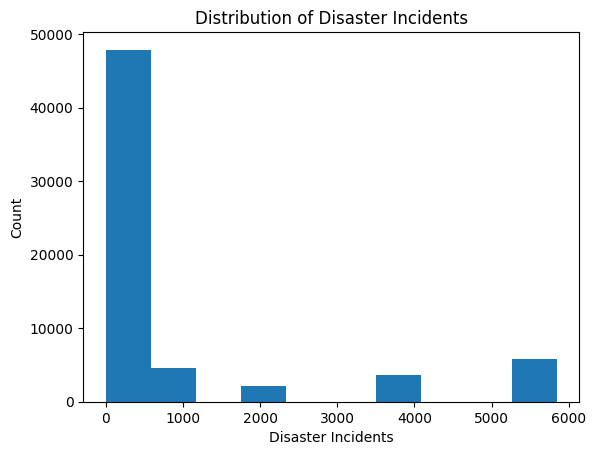

In [59]:
# Plot data as a historgram as you normally would for any numerical data
plt.title('Distribution of Disaster Incidents')
plt.hist(subset_df['counts'])
plt.xlabel('Disaster Incidents')
plt.ylabel('Count')
plt.show()

In [60]:
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64092 entries, 0 to 64091
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           64092 non-null  datetime64[ns]
 1   incident_type  64092 non-null  object        
 2   state          64092 non-null  object        
 3   doy            64092 non-null  int32         
 4   year           64092 non-null  int32         
 5   counts         64092 non-null  int64         
 6   Linear model   64092 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(2), int64(1), object(2)
memory usage: 2.9+ MB


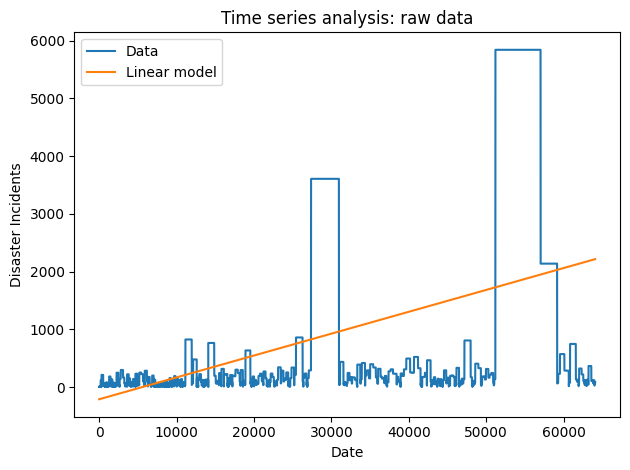

In [61]:
# Plot timeseries
# Plot the data over time and include the linear regression from above
plt.title('Time series analysis: raw data')
plt.plot(subset_df['counts'], label='Data')
plt.plot(subset_df['Linear model'], label='Linear model')
plt.xlabel('Date')
plt.ylabel('Disaster Incidents')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### 2.4 Feature Selection

### 2.5 Feature Engineering